#강화학습 실습(Grid World)

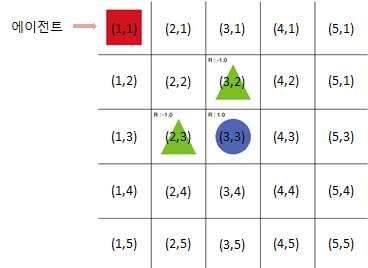

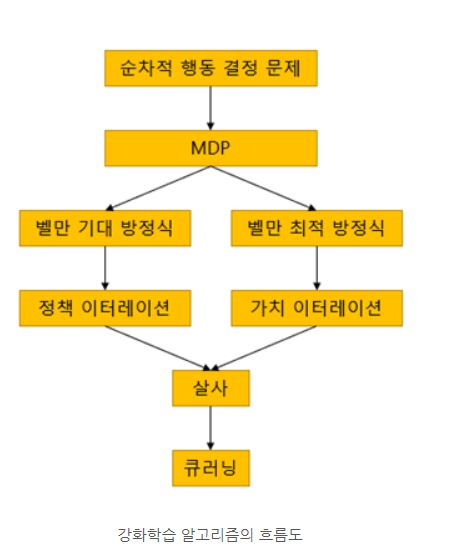

#GridWorld.py 1st version


https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/gridworld.py

In [13]:
import numpy as np

# global variables
BOARD_ROWS = 3
BOARD_COLS = 4
WIN_STATE = (0, 3)
LOSE_STATE = (1, 3)
START = (2, 0)
DETERMINISTIC = True


class State:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC

    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif self.state == LOSE_STATE:
            return -1
        else:
            return 0

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):
            self.isEnd = True

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position
        """
        if self.determine:
            if action == "up":
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == "down":
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == "left":
                nxtState = (self.state[0], self.state[1] - 1)
            else:
                nxtState = (self.state[0], self.state[1] + 1)
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (BOARD_ROWS -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (BOARD_COLS -1)):
                    if nxtState != (1, 1):
                        return nxtState
            return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')


# Agent of player

class Agent:

    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2
        self.exp_rate = 0.3

        # initial state reward
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0  # set initial value to 0

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                # if the action is deterministic
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()

    def play(self, rounds=10):
        i = 0
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                # explicitly assign end state to reward values
                self.state_values[self.State.state] = reward  # this is optional
                print("Game End Reward", reward)
                for s in reversed(self.states):
                    reward = self.state_values[s] + self.lr * (reward - self.state_values[s])
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                # append trace
                self.states.append(self.State.nxtPosition(action))
                print("current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                print("nxt state", self.State.state)
                print("---------------------")

    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')


if __name__ == "__main__":
    ag = Agent()
    ag.play(50)
    print(ag.showValues())

current position (2, 0) action down
nxt state (2, 0)
---------------------
current position (2, 0) action left
nxt state (2, 0)
---------------------
current position (2, 0) action right
nxt state (2, 1)
---------------------
current position (2, 1) action right
nxt state (2, 2)
---------------------
current position (2, 2) action right
nxt state (2, 3)
---------------------
current position (2, 3) action up
nxt state (1, 3)
---------------------
Game End Reward -1
current position (2, 0) action up
nxt state (1, 0)
---------------------
current position (1, 0) action right
nxt state (1, 0)
---------------------
current position (1, 0) action right
nxt state (1, 0)
---------------------
current position (1, 0) action right
nxt state (1, 0)
---------------------
current position (1, 0) action up
nxt state (0, 0)
---------------------
current position (0, 0) action right
nxt state (0, 1)
---------------------
current position (0, 1) action right
nxt state (0, 2)
---------------------
curr

# GridWorld.py 2nd version

https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/gridworld.py


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import collections
import numpy as np
import copy

# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32



class GridWorld():
    def __init__(self, W, H):
        self.x = 2
        self.y = 2
        self.W = W-1
        self.H = H-1
        self.apple_x = random.randrange(start = 1, stop = self.H)
        self.apple_y = random.randrange(start = 1, stop = self.W)
        self.data = [[0] * 5 for _ in range(5)]

        # 사과 위치
        self.data[self.apple_x][self.apple_y] = 2

        # 사과를 찾은 횟수
        self.cnt = 0


    def step(self, a, show = False):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a == 0:
            self.move_left()
        elif a == 1:
            self.move_up()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_down()

        find = self.is_find()
        if find:
            reward = 1
        else:
            reward = -1  # 보상은 항상 -1로 고정

        if show:
            self.show_data()

        return np.array([self.x, self.y, self.apple_x, self.apple_y]), reward, find

    def move_right(self):
        self.y += 1
        if self.y > self.W:
            self.y = self.W

    def move_left(self):
        self.y -= 1
        if self.y < 0:
            self.y = 0

    def move_up(self):
        self.x -= 1
        if self.x < 0:
            self.x = 0

    def move_down(self):
        self.x += 1
        if self.x > self.H:
            self.x = self.H

    def is_find(self):
        if self.x == self.apple_x and self.y == self.apple_y:
            self.set_apple()
            return True
        else:
            return False

    def set_apple(self):
        X, Y = self.find_nothing()
        idx = random.randrange(start=0, stop = len(X))
        self.data[self.apple_x][self.apple_y] = 0 # 사과 위치 초기화
        self.apple_x = X[idx]
        self.apple_y = Y[idx]

        self.data[self.apple_x][self.apple_y] = 2  # 사과 위치

    def find_nothing(self):
        # 0의 위치 찾기 // 사과 제외
        X, Y = [], []
        for h in range(self.H+1):
            if sum(self.data[h]) < self.H+1 and 2 not in self.data[h]:
                for w in range(self.W+1):
                    if self.data[h][w] == 0:
                        X.append(h)
                        Y.append(w)
        return X, Y



    def get_state(self):
        return np.array([self.x, self.y, self.apple_x, self.apple_y])

    def reset(self):
        self.x = 0
        self.y = 0

        self.data[self.apple_x][self.apple_y] = 0

        self.apple_x = random.randrange(start=1, stop=self.H)
        self.apple_y = random.randrange(start=1, stop=self.W)

        return np.array([self.x, self.y, self.apple_x, self.apple_y])

    def show_data(self):
        data = copy.deepcopy(self.data)
        data[self.x][self.y] = -9

        for idx, row in enumerate(data):
            print(row)


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 3)
        else:
            return out.argmax().item()


def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



env = GridWorld(W = 5, H = 5)
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = 0.0
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_epi in range(10000):
    epsilon = max(0.01, 0.8 - 0.01 * (n_epi / 200))  # Linear annealing from 80% to 1%
    s = env.reset()
    find = False

    while not find:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, find = env.step(a)
        done_mask = 0.0 if find else 1.0
        memory.put((s, a, r / 100.0, s_prime, done_mask))
        s = s_prime

        score += r
        if find:
            break

    if memory.size() > 2000:
        train(q, q_target, memory, optimizer)

    if n_epi % print_interval == 0 and n_epi != 0:
        q_target.load_state_dict(q.state_dict())
        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
            n_epi, score / print_interval, memory.size(), epsilon * 100))

        score = 0.0

n_episode :20, score : -63.0, n_buffer : 1301, eps : 79.9%
n_episode :40, score : -69.5, n_buffer : 2730, eps : 79.8%
n_episode :60, score : -67.2, n_buffer : 4115, eps : 79.7%
n_episode :80, score : -72.5, n_buffer : 5604, eps : 79.6%
n_episode :100, score : -50.0, n_buffer : 6643, eps : 79.5%
n_episode :120, score : -81.5, n_buffer : 8314, eps : 79.4%
n_episode :140, score : -50.9, n_buffer : 9372, eps : 79.3%
n_episode :160, score : -55.4, n_buffer : 10519, eps : 79.2%
n_episode :180, score : -76.0, n_buffer : 12078, eps : 79.1%
n_episode :200, score : -76.7, n_buffer : 13652, eps : 79.0%
n_episode :220, score : -77.6, n_buffer : 15244, eps : 78.9%
n_episode :240, score : -106.8, n_buffer : 17419, eps : 78.8%
n_episode :260, score : -71.5, n_buffer : 18889, eps : 78.7%
n_episode :280, score : -73.7, n_buffer : 20403, eps : 78.6%
n_episode :300, score : -91.5, n_buffer : 22273, eps : 78.5%
n_episode :320, score : -65.6, n_buffer : 23625, eps : 78.4%
n_episode :340, score : -75.8, n_b

#Vis

In [15]:
q.eval()

Qnet(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

s = env.reset()

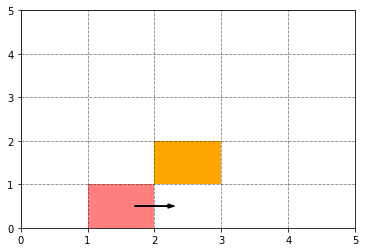

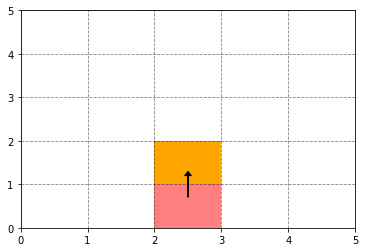

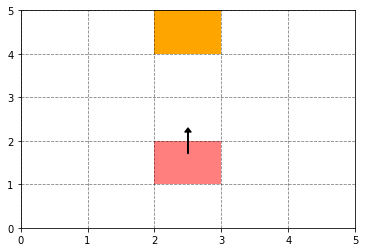

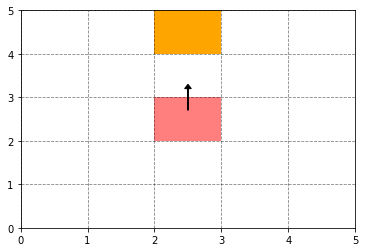

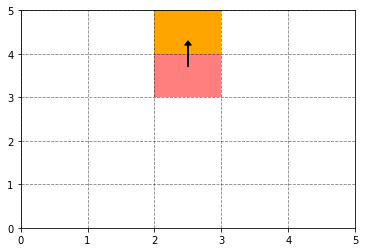

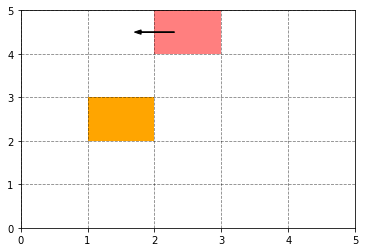

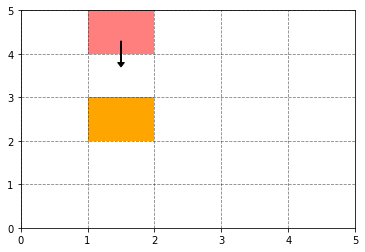

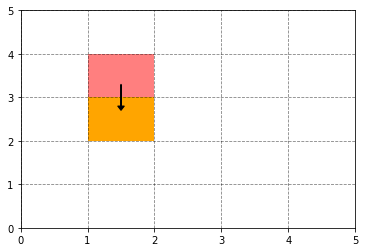

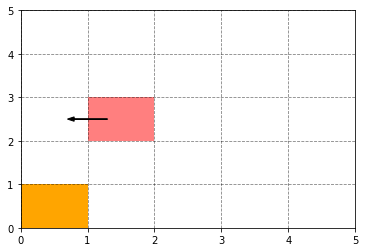

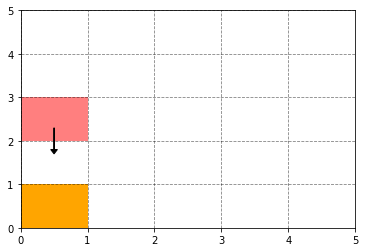

In [17]:
for _ in range(10):
  a = q.sample_action(torch.from_numpy(s).float(), 0)
  s_prime, r, find = env.step(a)
  s = s_prime
  a = q.sample_action(torch.from_numpy(s).float(), 0)

  W, H = 5, 5
  self_x, self_y = env.x, env.y
  self_apple_x, self_apple_y = env.apple_x, env.apple_y

  x = np.arange(0, W+1, 1)
  y = np.arange(0, H+1, 1)

  plt.plot()
  plt.grid(True, axis = 'y', color = 'black', alpha = 0.5, linestyle= '--')
  plt.grid(True, axis = 'x', color = 'black', alpha = 0.5, linestyle= '--')
  plt.axis([0, W, 0, H])

  # agent
  plt.fill([self_x, self_x, self_x+1, self_x+1], [self_y, self_y+1, self_y+1, self_y], facecolor = 'red', alpha = 0.5)

  # action vis
  if a == 1:
      plt.arrow(self_x+0.3, self_y+0.5, -0.5, 0, facecolor = 'k', ec = 'k', head_width = 0.1, head_length = 0.1)
  elif a == 2:
      plt.arrow(self_x+0.5, self_y+0.7, 0, 0.5, facecolor = 'k', ec = 'k', head_width = 0.1, head_length = 0.1)
  elif a == 3:
      plt.arrow(self_x+0.7, self_y+0.5, 0.5, 0, facecolor = 'k', ec = 'k', head_width = 0.1, head_length = 0.1)
  elif a == 0:
      plt.arrow(self_x+0.5, self_y+0.3, 0, -0.5, facecolor = 'k', ec = 'k', head_width = 0.1, head_length = 0.1)


  # apple
  plt.fill([self_apple_x, self_apple_x, self_apple_x+1, self_apple_x+1], [self_apple_y, self_apple_y+1, self_apple_y+1, self_apple_y], facecolor = 'orange')
  plt.show()